# Flight Condition Normalization 

Following the ideas from: [Remaining Useful Life Prediction of Aircraft Engines with Variable Length Input Sequences](https://papers.phmsociety.org/index.php/phmconf/article/view/3108) PHM2021 data challenge competition winner

In [27]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import joblib
import torch
import torch.nn as nn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, Checkpoint

from src.pipelines.ocnorm import EstimationPipeline,HealthIndexTransformer, OperCondResidualAggregator, to_float32
from src.models.operating_condition_mlp import OperatingConditionMLP
from src.helpers.seed import set_global_seed


## Configuration

In [28]:
SEED = 42
data_name = "DS01"

In [29]:
# Paths
experiment_dir = Path('experiments')/data_name
opcond_dir = experiment_dir/'opcond'
checkpoint_dir = opcond_dir/'checkpoints'



opcond_cols = ["alt", "Mach", "TRA", "T2", "Fc", "pos"]
num_cols = ["alt", "Mach", "TRA", "T2", "pos"]
performance_cols = ["T48", "SmFan", "SmLPC", "SmHPC"]

unit_col = "unit"
cycle_col = "cycle"
hs_col = "hs"

device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(checkpoint_dir, exist_ok=True)

In [30]:
set_global_seed(SEED)

## 1. Load dataset

In [31]:
df = pd.read_csv(experiment_dir/'data_dev.csv',dtype={"Fc": str})
df.T

,0,1,2,3,4,5,6,7,8,9,...,490656,490657,490658,490659,490660,490661,490662,490663,490664,490665
index,0,10,20,30,40,50,60,70,80,90,...,4906536,4906546,4906556,4906566,4906576,4906586,4906596,4906606,4906616,4906626
alt,3013.0,3088.0,3163.0,3234.0,3308.0,3404.0,3500.0,3598.0,3689.0,3775.0,...,3569.0,3537.0,3498.0,3442.0,3391.0,3346.0,3297.0,3228.0,3150.0,3063.0
Mach,0.376362,0.379827,0.385497,0.390915,0.394317,0.397215,0.398349,0.39816,0.398916,0.400491,...,0.225477,0.218358,0.210294,0.213948,0.214137,0.205758,0.206073,0.196749,0.199647,0.20412
TRA,70.311996,70.399887,70.575668,70.575668,70.575668,70.663559,71.103012,71.103012,71.103012,71.190903,...,26.01544,26.54278,26.54278,26.54278,31.816179,31.991961,31.728291,31.728291,31.728291,31.728291
T2,522.31477,522.305436,522.470679,522.636427,522.635789,522.514853,522.252063,521.878065,521.603341,521.413768,...,511.086023,510.879475,510.672727,511.030502,511.217671,511.028314,511.216516,511.085922,511.481771,511.978949
T24,618.2886,618.33136,618.648,618.8117,618.78326,618.70416,618.72754,618.36127,618.02167,617.8686,...,562.4298,562.7625,562.7365,563.0967,568.0089,569.1801,569.10583,569.06134,569.464,569.981
T30,1470.4698,1470.4551,1471.0807,1471.0198,1470.7172,1470.5281,1471.4504,1470.538,1469.7578,1469.4851,...,1250.8418,1253.753,1253.743,1254.3527,1283.5458,1284.2975,1283.4062,1283.5751,1284.3556,1285.2705
T48,1849.6207,1849.5927,1850.5286,1850.052,1849.4564,1849.233,1851.9468,1850.1536,1849.1177,1848.8566,...,1493.1752,1500.4933,1499.0494,1499.5115,1564.0657,1554.8971,1553.0721,1553.3749,1554.5061,1555.3907
T50,1269.2756,1268.8374,1268.7753,1268.0115,1267.3253,1266.7612,1267.9312,1266.4662,1265.6602,1265.1698,...,1137.9164,1141.9175,1140.8643,1141.0939,1172.1315,1163.3936,1162.9027,1163.461,1164.2698,1164.8124
P15,19.43207,19.41583,19.426363,19.427917,19.40798,19.373125,19.337872,19.270197,19.21225,19.171629,...,15.556688,15.572701,15.569547,15.616114,15.905516,15.953566,15.969251,15.974545,16.031763,16.10052


## Operation Condition Normalization Procedure

Learn $f: X\mapsto Y$ frp, the flight conditions $X$ to the sensor outputs/performance metrics $Y$

$X$ Consist of 6 features, 4 flight conditions, 
* flight mach number (mach)
* altitude (alt)
* throttle resolve angle (TRA) 
* total fan inlet temperature (T2)
* flight class, a categorical feature describing the  flight length(Fc)
* positional variable of time elapsed within the flight cycle (pos)

**Note:** The paper says 5 features but they enumerate 6. 

* Performance metrics: $T48$, $SmFan$, $SmLPC$, $SmHPC$

## Train

## OC normalization pipeline (learns nominal behavior)

In [32]:
input_dim = len(num_cols) + df["Fc"].nunique()
output_dim = len(performance_cols)

callbacks = [
    EarlyStopping(
        monitor="valid_loss",
        patience=10,
        threshold=1e-4,
    ),
	Checkpoint(
    monitor="valid_loss_best",
    f_params=str(checkpoint_dir/"best_model.pt"),
    f_optimizer=str(checkpoint_dir/"best_optimizer.pt"),
    f_history=str(checkpoint_dir/"history.json"),
    f_criterion=str(checkpoint_dir/"criterion.pt"),
)]

oc_net = NeuralNetRegressor(
    OperatingConditionMLP,
    module__input_dim=input_dim,
    module__output_dim=output_dim,
    max_epochs=100,
    lr=5e-4,
    optimizer=torch.optim.AdamW,
    optimizer__weight_decay=1e-3,
    criterion=nn.MSELoss,
    iterator_train__shuffle=True,
    device=device,
    callbacks=callbacks,
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Fc"]),
    ],
    remainder="drop",   # or "passthrough" if needed
)

oc_pipe = Pipeline([
    ("preprocess", preprocess),
    ("to_float32", FunctionTransformer(to_float32)),
    ("mlp", oc_net),
])

In [ ]:
residual_aggregator = OperCondResidualAggregator(
        oc_pipe=None,
        opcond_cols=opcond_cols,
        perform_cols=performance_cols,
        unit_col=unit_col,
        cycle_col=cycle_col,
    )
hi_transformer=HealthIndexTransformer(
        metrics=performance_cols,
        cycle_col=cycle_col,
        q_low=0.01,
        q_high=0.99,
        corr_thresh=0.6,
    )

full_pipe = EstimationPipeline(
    oc_pipe,
    residual_aggregator,
    hi_transformer,
    hs_col=hs_col,
)


full_pipe.fit(df)

## Save the pipeline 

In [ ]:
joblib.dump(full_pipe, opcond_dir/"pipeline_best.joblib")

['experiments/DS01/opcond/pipeline_best.joblib']

## Load the pipeline

In [ ]:
pipe:EstimationPipeline = joblib.load(opcond_dir/"pipeline_best.joblib")
pipe.set_bounds(df,q_low=0.01, q_high=0.99)
df_hi = pipe.transform(df)

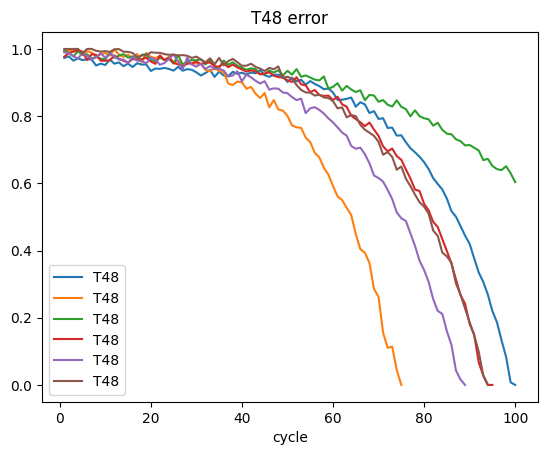

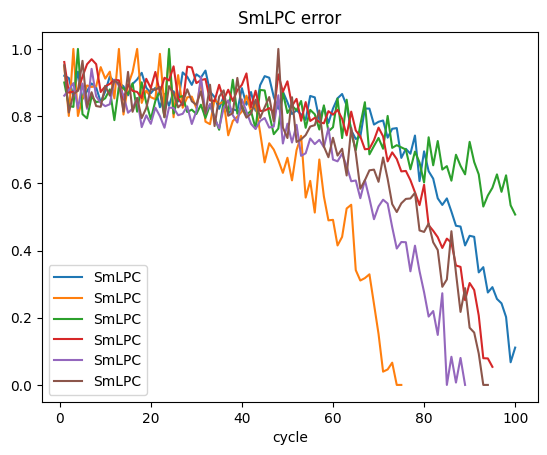

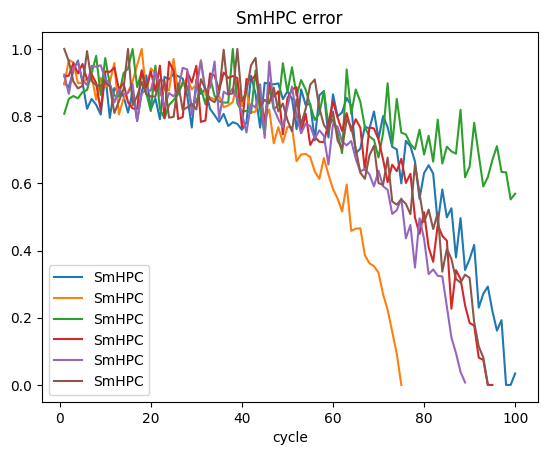

In [ ]:
for perf in pipe.get_performances():
    fig, ax = plt.subplots()
    ax.set_title(f"{perf} error")
    df_hi.groupby("unit").plot(x="cycle", y=f'{perf}', ax=ax, legend=True)